<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/1_Introduction_to_pybinding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: how to use the notebooks and pybinding

The atomic orbitals can be used as a basis to write down a matrix representation for the Hamiltonian operator, which can then be diagonalized to find the energy eigenvalues. Instead of having to write our 2D Hamiltonian in a complicated matrix, we are going to use an awesome python package named [*Pybinding*](https://docs.pybinding.site/). If you are familiar with python you can install pybinding on your python enviroment with pip. Otherwise, you can use our notebooks in *google colab*.
Let us play a bit and see how simple it can be. We will begin by importing pybinding as pb so that all *Pybinding* functions begin with a pb.

* The first two lines install a few libraries that we will
use and are not included in google colab. *Pybinding* has a set of cool features to work with tight-binding Hamiltonians while *Quantum Kite* performs quantum transport calculations.
* The other are mathematical and graphical libraries for python.


In [25]:

!pip install h5py==3.11.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.4


import numpy as np
from math import sqrt, pi
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})




Looking in indexes: https://test.pypi.org/simple/



 After that, let us try to define a square lattice with one atom per unit cell and plot it. To define a lattice, we need to give the position of the atomic orbitals in the unit cell, the two lattice vectors and the hopping integrals connecting the atomic orbitals.



First, we need to define the lattice but in *Pybinding* we only need to define the unit cell and the "connections" between unit cells. This will be our lattice.

**From PB:**
A lattice object describes the unit cell of a crystal lattice. This includes the primitive vectors, positions of sublattice sites and hopping parameters which connect those sites. All of this structural information is used to build up a larger system by translation, using the translation symmetry.
With the lattice object, it is also possible to plot its Brillouin zone, which is basically the unit cell in the reciprocal space.

But what about DFT calculations? They can be used to extract the tight-binding parameters that work as the input for *Pybinding* and quantum Kite. We will discuss this at the very end.

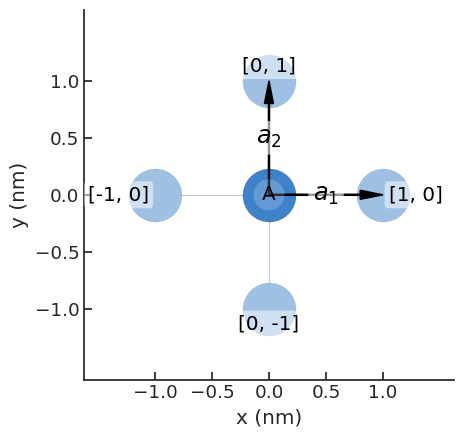

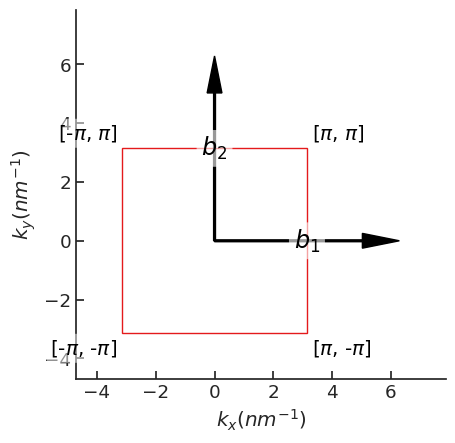

In [26]:


def square_lattice(d, t):
    lat = pb.Lattice(a1=[d, 0], a2=[0, d])
    lat.add_sublattices(('A', [0, 0]))
    lat.add_hoppings(([0, 1], 'A', 'A', -t),
                     ([1, 0], 'A', 'A', -t))
    return lat

# we can quickly set a shorter unit length `d`
d=1
lattice = square_lattice(d, t=1)
lattice.plot()
plt.show()
lattice.plot_brillouin_zone()


After defining the lattice, one can define a model which isn't a lattice. A model contains the full tight-binding description of the physical system that we wish to solve (although the hoppings were defined in the lattice instance). The model can be periodic or finite and there is a lot of flexibility to define a model. Here, we include translational_symmetry() to create an infinite square lattice.

We then define the numerical solver to diagonalize our system. One safe choice is lapack, extensivelly used in different enviroments. As we solve in k-space, we also need to define a point the Brillouin zone. We need to define what pair of $(k_x,k_y)$ will be used for the calculation of our energies and eigenfunctions.

In the example below, we are not defining a pair of $(k_x,k_y)$ in a path in the Brillouin zone (BZ) where the band structure will be calculated. Pybinding allows it to draw the path in the BZ. With the solver, it is possible to extract the band structure, the eigenvectors and also other derived quantities that we will see later.

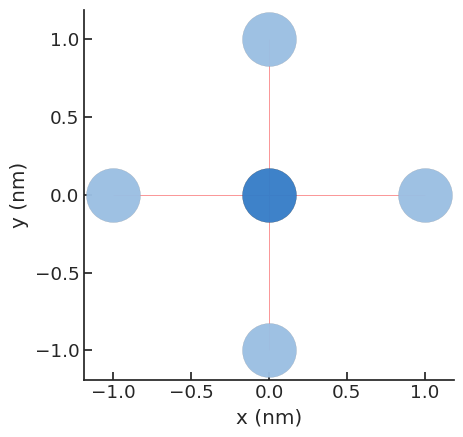

In [27]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot()
plt.show()

We then define the numerical solver to diagonalize our system. One safe choice is lapack, extensivelly used in different enviroments.

In [28]:
solver = pb.solver.lapack(model)

As we solve in k-space, we also need to define a point the Brillouin zone. We need to define what pair of (𝑘𝑥,𝑘𝑦) will be used for the calculation of our energies and eigenfunctions. Pybinding allows it to draw the path in the BZ.

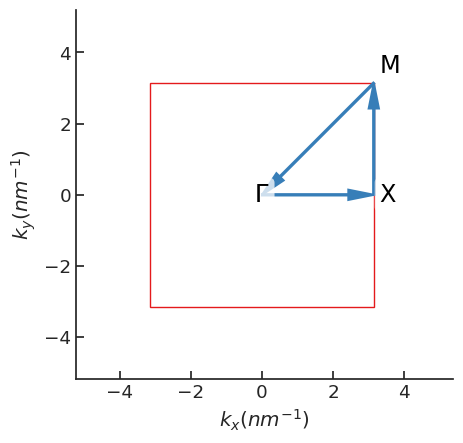

In [29]:
Gamma =[0,0]
X = [pi/d,0]
Xn = [-pi/d,0]
M = [pi/d,pi/d]
bands = solver.calc_bands(Gamma,X, M, Gamma)
model.lattice.plot_brillouin_zone(decorate=False)
bands.plot_kpath(point_labels=['$\Gamma$','X','M','$\Gamma$'])
plt.show()

We can now plot the band structure using the same path

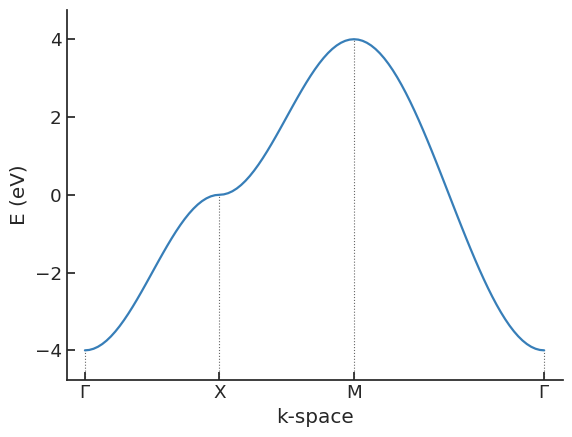

In [30]:

bands.plot(point_labels=['$\Gamma$','X','M','$\Gamma$'])
plt.show()

Or recalculate the bandstructure and plot it using a different path:

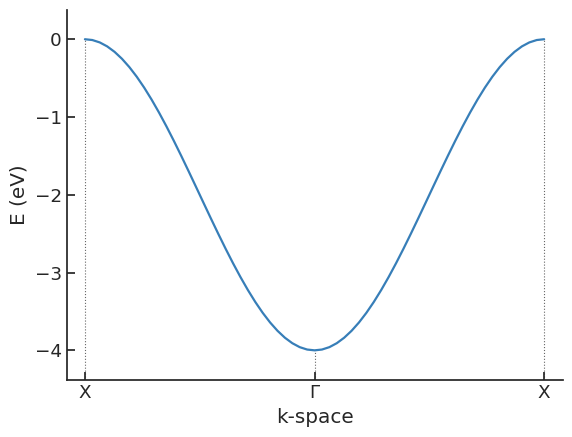

In [31]:

bands = solver.calc_bands(Xn,Gamma,X)
bands.plot(point_labels=['X','$\Gamma$','X'])
plt.show()



Let us now go  to a one-dimensional model but we where we add two different sites in a single unit cell. Check the book of Datta for this example and the analytical solution.

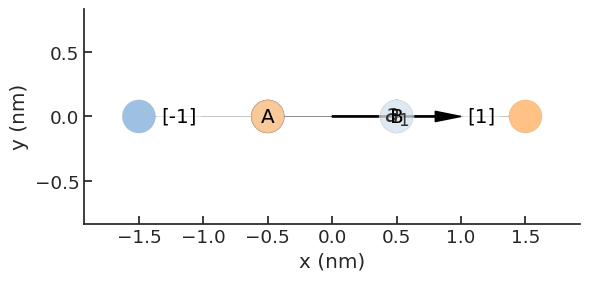

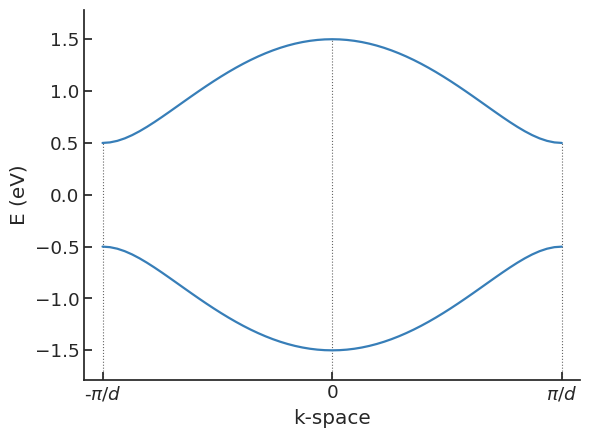

In [32]:
def line_lattice(d, t):
    lat = pb.Lattice(a1=[d, 0])
    lat.add_sublattices(("A", [-d / 2, 0]), ("B", [d / 2, 0]))
    lat.add_hoppings(([0, 0], "A", "B", t / 2), ([1, 0], "B", "A", t))
    return lat


# we can quickly set a shorter unit length `d`
d = 1
lattice = line_lattice(d, t=1)
lattice.plot()
plt.show()
model = pb.Model(line_lattice(d, t=1), pb.translational_symmetry())
solver = pb.solver.lapack(model)
Gamma = [0, 0]
X = [pi / d, 0]
Xn = [-pi / d, 0]
bands = solver.calc_bands(Xn, Gamma, X)
bands.plot(point_labels=["-$\pi/d$", "0", "$\pi/d$"])
plt.show()


Now that we know how to include two sites per unit cell, we are ready to calculate the band structure of graphene. Although we could define the lattice, as we find in [pybinding tutorial](https://docs.pybinding.site/en/stable/tutorial/lattice.html), we will use the pre-defined graphene lattice it already has (!) and use it to plot its band structure. Pybinding has a library with different tight-binding models for 2D materials like TMDs and phosphorene. But you can always construct your own.

We will use periodic boundary conditions and a simple translational symmetry in pybinding. But we can use other setups like finite system and superlattices.

In [33]:
from pybinding.repository import graphene

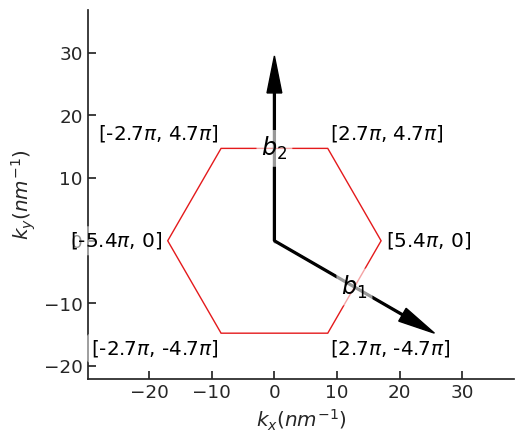

In [34]:
model = pb.Model(
    graphene.monolayer(),
    pb.translational_symmetry()
)
model.plot()

model.lattice.plot_brillouin_zone(decorate=True)
plt.show()

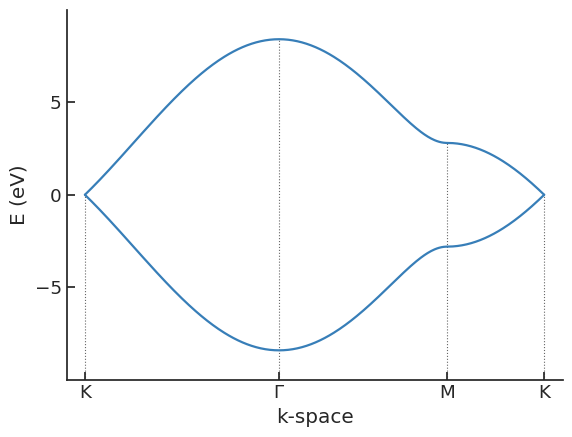

In [35]:
solver = pb.solver.lapack(model)  # eigensolver from the LAPACK library

# significant points in graphene's Brillouin zone
a_cc = graphene.a_cc  # carbon-carbon distance
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]
M = [0, 2*pi / (3*a_cc)]
K2 = [2*pi / (3*sqrt(3)*a_cc), 2*pi / (3*a_cc)]

# plot the bands through the desired points
bands = solver.calc_bands(K1, Gamma, M, K2)

bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'K'])
plt.show()


We can work with finite systems in pybinding. As they can have different geometries, let us see how to define a geometrical object there. To define and plot a rectangle:



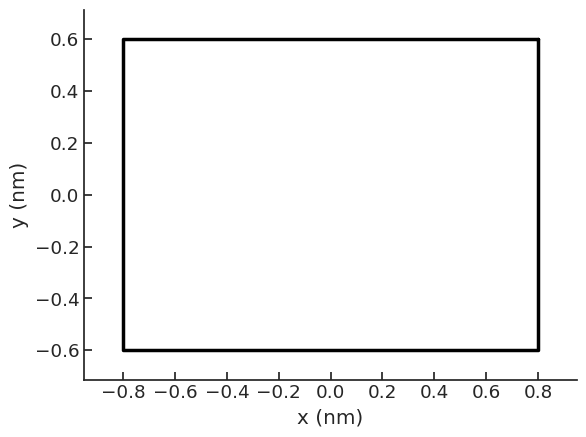

In [36]:
def rectangle(width, height):
    x0 = width / 2
    y0 = height / 2
    return pb.Polygon([[x0, y0], [x0, -y0], [-x0, -y0], [-x0, y0]])

shape = rectangle(1.6, 1.2)
shape.plot()

or a ring...

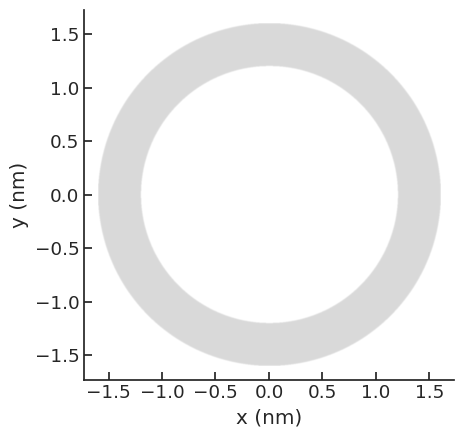

In [37]:
def ring(inner_radius, outer_radius):
    """Ring shape defined by an inner and outer radius"""
    def contains(x, y, z):
        r = np.sqrt(x**2 + y**2)
        return np.logical_and(inner_radius < r, r < outer_radius)
    return pb.FreeformShape(contains, width=[2*outer_radius, 2*outer_radius])
shape = ring(1.2, 1.6)
shape.plot()

We can model a finite system instead of using the translational symmetry and we can definde the model in any geometry if we define this geometry first

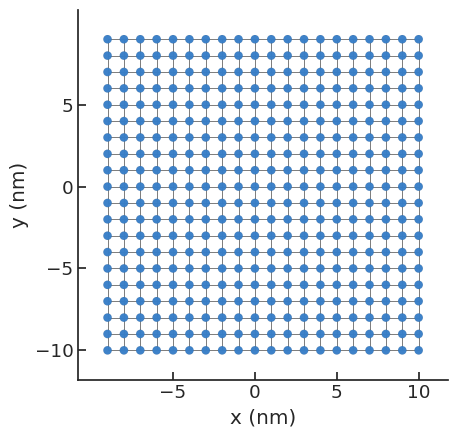

In [38]:
model = pb.Model(
    square_lattice(1,1),
    rectangle(width=20, height=20)
)
model.plot()

Now we can proceed like before. We define a solver and calculate the eigenvalues. The main difference is that for periodic models the system is diagonalized in k space and we define the points in $k$ space where we want the eigenvalues. Here, in a finite system, the eigenvalues are just ordered in energy and can be ploted in function of the state number



(-4.0, -2.0)

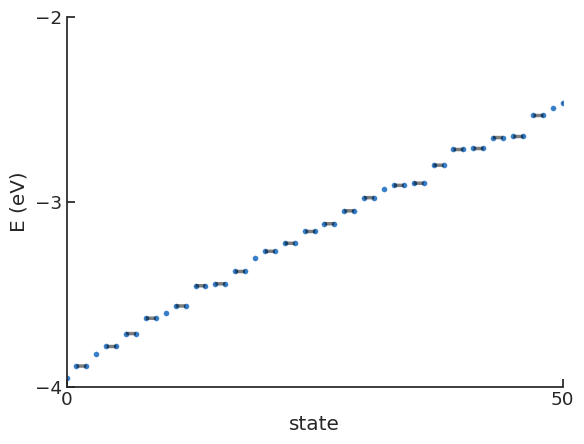

In [39]:
solver = pb.solver.lapack(model)
eigenvalues = solver.calc_eigenvalues()
eigenvalues.plot()
plt.xlim(0,50)
plt.ylim(-4,-2)

There are ways to have an visualize the eigenvectors by plotting the probability density of a given eigenstate $\psi_n$, given by $|\psi_n(\vec{r})|^2$.

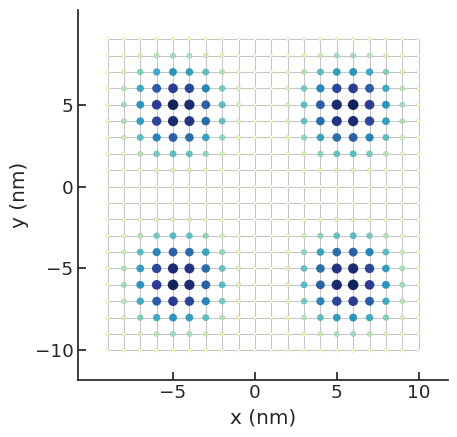

In [40]:
probability_map = solver.calc_probability(3)
probability_map.plot(site_radius=(0.1, 0.32))

We can also have a system that is periodic in a given direction and finite in the other. In general, as we need to use the lattice vectors to define where the system is periodic, it gives the geometry of the new system. However, it is also possible to define a finite piece of a lattice as the new unit cell of a superlattice. This is necessary if we want to construct a graphene nanoribbon with armchair edges. Let us see two examples using graphene: one with zigzag edges and another with armchair edges.

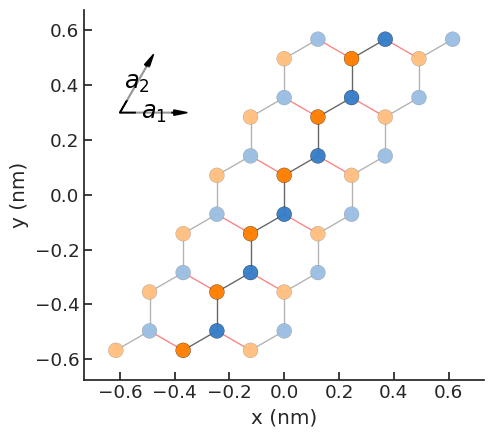

In [41]:
from pybinding.repository import graphene

model = pb.Model(
    graphene.monolayer(),
    pb.rectangle(1.2),  # nm
    pb.translational_symmetry(a1=True, a2=False)
)
model.plot()
model.lattice.plot_vectors(position=[-0.6, 0.3])  # nm

After defining the ribbon, which is periodic in a given direction and finite in the other (light color indicates the orientation of the periodic part), we can now solve the Hamiltonian and find the eigenvalues (band) for a path in k-space (that now it has only one dimension). We can see that both edges have zigzag structure.

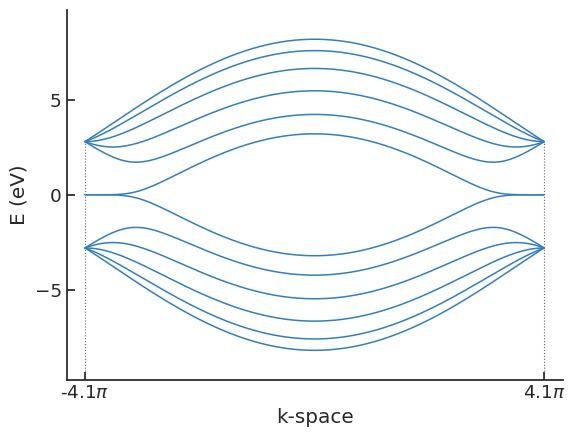

In [42]:
from math import pi, sqrt

solver = pb.solver.lapack(model)
a = graphene.a_cc * sqrt(3)  # ribbon unit cell length
bands = solver.calc_bands(-pi/a, pi/a)
bands.plot()

This is the characteristic band structure for zigzag nanoribbons with zero-energy edge states. To actually see these are edge states, we can calculate the local density of states at $E=0$ eV for a given wave vector $k=\pi/a$:

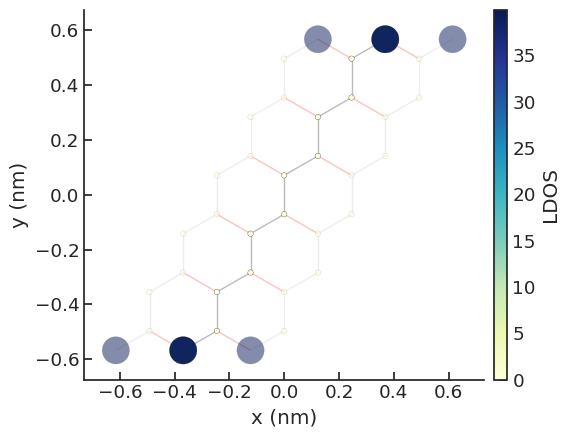

In [43]:
solver.set_wave_vector(k=pi/a)
ldos = solver.calc_spatial_ldos(energy=0, broadening=0.01)  # LDOS around 0 eV

ldos.plot(site_radius=(0.01, 0.05))
pb.pltutils.colorbar(label="LDOS")
plt.show()

For an armchair edge, it is better to use the pre-defines graphene lattice with 4 atoms per unit cell where the two lattice vectors are parallel to  𝑥  and  𝑦 :

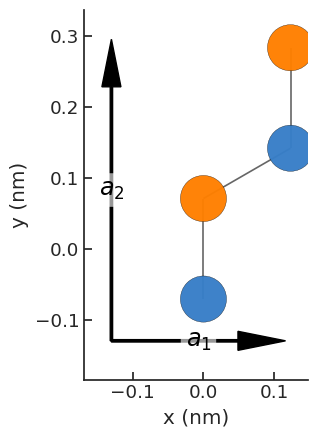

In [44]:
model = pb.Model(graphene.monolayer_4atom())
model.plot()
model.lattice.plot_vectors(position=[-0.13, -0.13])

with this new lattice, we can construct the ribbon

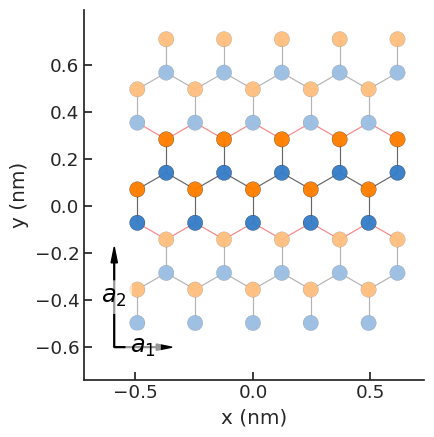

In [45]:
model = pb.Model(
    graphene.monolayer_4atom(),
    pb.primitive(a1=5),
    pb.translational_symmetry(a1=False, a2=True)
)
model.plot()
model.lattice.plot_vectors(position=[-0.59, -0.6])

One can see that we constructed a ribbon with armchair terminations. We can now solve and obtain the band structure that does not have edge states:

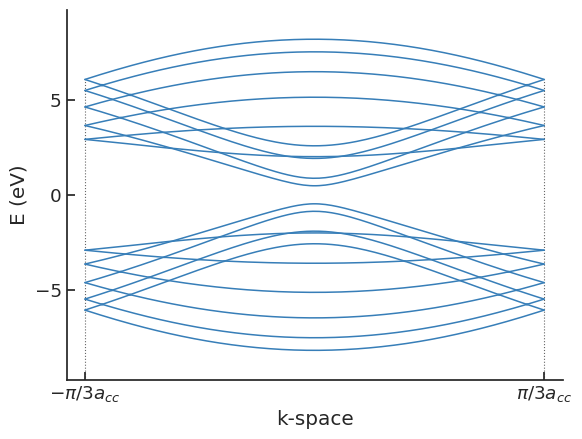

In [46]:
solver = pb.solver.lapack(model)
d = 3 * graphene.a_cc  # ribbon unit cell length
bands = solver.calc_bands([0, -pi/d], [0, pi/d])
bands.plot(point_labels=['$-\pi / 3 a_{cc}$', '$\pi / 3 a_{cc}$'])
